In [71]:
# Running All Imports

import numpy as np
from numpy import ndarray
import matplotlib.pyplot as plt
%matplotlib inline

from qiskit import IBMQ, pulse, schedule

from qiskit.circuit import Parameter, QuantumCircuit, Gate
from qiskit.tools.monitor import job_monitor

from qiskit.visualization.pulse_v2 import stylesheet

from scipy.optimize import curve_fit

from typing import Optional, Union

IBMQ.load_account()

ibmqfactory.load_account:WARNING:2024-01-08 03:41:11,699: Credentials are already in use. The existing account in the session will be replaced.


<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [72]:
provider = IBMQ.get_provider(hub='ibm-q-nus', group='default', project='default')
provider.backends()

[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q-nus', group='default', project='default')>,
 <IBMQBackend('ibmq_kolkata') from IBMQ(hub='ibm-q-nus', group='default', project='default')>,
 <IBMQBackend('ibmq_mumbai') from IBMQ(hub='ibm-q-nus', group='default', project='default')>,
 <IBMQSimulator('simulator_statevector') from IBMQ(hub='ibm-q-nus', group='default', project='default')>,
 <IBMQSimulator('simulator_mps') from IBMQ(hub='ibm-q-nus', group='default', project='default')>,
 <IBMQSimulator('simulator_extended_stabilizer') from IBMQ(hub='ibm-q-nus', group='default', project='default')>,
 <IBMQSimulator('simulator_stabilizer') from IBMQ(hub='ibm-q-nus', group='default', project='default')>,
 <IBMQBackend('ibm_hanoi') from IBMQ(hub='ibm-q-nus', group='default', project='default')>,
 <IBMQBackend('ibm_algiers') from IBMQ(hub='ibm-q-nus', group='default', project='default')>,
 <IBMQBackend('ibm_cairo') from IBMQ(hub='ibm-q-nus', group='default', project='default')>,
 <IBMQ

In [73]:
DEBUG_PRINT = False

backend = provider.get_backend('ibm_cairo') # replace the name with the exact one for the backend that is desired from the previous displayed backends
backend_config = backend.configuration()
assert backend_config.open_pulse, "Backend doesn't support Pulse"

dt = backend_config.dt # Example way of getting data on the backend
backend_defaults = backend.defaults() 

acquire_alignment = backend.configuration().timing_constraints['acquire_alignment']
granularity = backend.configuration().timing_constraints['granularity']
pulse_alignment = backend.configuration().timing_constraints['pulse_alignment']

lcm = np.lcm(acquire_alignment, pulse_alignment)

# unit conversion factors -> all backend properties returned in SI (Hz, sec, etc.)
GHz = 1.0e9 # Gigahertz
MHz = 1.0e6 # Megahertz
us = 1.0e-6 # Microseconds
ns = 1.0e-9 # Nanoseconds

# Experiments will be run on these qubits
qubit_0 = 0
qubit_1 = 1

# The sweep will be centered around the estimated qubit frequency.
center_frequency_Hz_0 = backend_defaults.qubit_freq_est[qubit_0]
center_frequency_Hz_1 = backend_defaults.qubit_freq_est[qubit_1]

meas_freq_0 = backend_defaults.meas_freq_est[qubit_0]
meas_freq_1 = backend_defaults.meas_freq_est[qubit_1]

# scale factor to remove factors of 10 from the data
scale_factor = 1e-7

qubit = qubit_0

instruction_schedule_map = backend.defaults().instruction_schedule_map
measure_instructions = np.array(instruction_schedule_map.get("measure", qubits=[qubit]).instructions)
measure_pulse = measure_instructions[-2,1].pulse
measure_delay = measure_instructions[-1,1]

x_instructions = np.array(instruction_schedule_map.get("x", qubits=[qubit]).instructions)
x_pulse = x_instructions[0,1].pulse

sx_instructions = np.array(instruction_schedule_map.get("sx", qubits=[qubit]).instructions)
sx_pulse = sx_instructions[0,1].pulse

if DEBUG_PRINT:
    print(f"config: {backend_config}")

    for key, value in backend_config.to_dict().items():
        print(key)
        print(value)
    
    print(f"Sampling time: {dt*1e9} ns")    # The configuration returns dt in seconds, so multiply by
                                            # 1e9 to get nanoseconds

    backend_config.timing_constraints

    print(f"Least common multiple of acquire_alignment and pulse_alignment: {lcm}")

    print(f"Qubit {qubit_0} has an estimated frequency of {center_frequency_Hz_0 / GHz} GHz.")
    print(f"Qubit {qubit_1} has an estimated frequency of {center_frequency_Hz_1 / GHz} GHz.")

    print(f"Resonator for qubit {qubit_0} has an estimated frequency of {meas_freq_0 / GHz} GHz.")
    print(f"Resonator for qubit {qubit_1} has an estimated frequency of {meas_freq_1 / GHz} GHz.")

    print(f"measure_instructions: {measure_instructions}")

    print(f"measurement pulse: {measure_pulse}")
    print(f"measurement delay: {measure_delay}")
    print(f"x pulse: {x_pulse}")
    print(f"sx pulse: {sx_pulse}")

## Smart Tau 3 Calibration

Here we are going to calibrate the Tau 3 values, and also determine the necessary reset delay duration (Tau R)
1. Tau 3 Photon Scan with AC Stark based Photon Measurements
2. Also scan the Tau R by varying the Qubit Delay DT

In [74]:
from helper_funcs.utils import *

tau_1 = get_dt_from(46.2 * ns) * dt
tau_2 = get_dt_from(270 * ns) * dt

tau_3_est = 45 * ns
tau_3_span = 15 * ns
num_tau_3_exp = 5
tau_3_est_linspace = convert_arr_to_dt(
    np.linspace(
        -0.5 * tau_3_span + tau_3_est, 
        0.5 * tau_3_span + tau_3_est, 
        num_tau_3_exp
    )
)
print(tau_3_est_linspace/ns)

qubit_delay_dt_arr = np.array([64, 128, 256], dtype=np.int16)
print(qubit_delay_dt_arr)

freq_span = 10.0 * MHz
freq_center = 0. * MHz
num_freq_exp = 59
ac_freq_linspace = np.linspace(-0.5 * freq_span + freq_center, 0.5 * freq_span + freq_center, num_freq_exp)
print(ac_freq_linspace/MHz)
print(f"precision: {(ac_freq_linspace[1] - ac_freq_linspace[0]) / MHz}MHz")

print(f"Total Exp Size: {num_tau_3_exp * len(qubit_delay_dt_arr) * num_freq_exp}")

[39.11111111 42.66666667 46.22222222 49.77777778 53.33333333]
[ 64 128 256]
[-5.         -4.82758621 -4.65517241 -4.48275862 -4.31034483 -4.13793103
 -3.96551724 -3.79310345 -3.62068966 -3.44827586 -3.27586207 -3.10344828
 -2.93103448 -2.75862069 -2.5862069  -2.4137931  -2.24137931 -2.06896552
 -1.89655172 -1.72413793 -1.55172414 -1.37931034 -1.20689655 -1.03448276
 -0.86206897 -0.68965517 -0.51724138 -0.34482759 -0.17241379  0.
  0.17241379  0.34482759  0.51724138  0.68965517  0.86206897  1.03448276
  1.20689655  1.37931034  1.55172414  1.72413793  1.89655172  2.06896552
  2.24137931  2.4137931   2.5862069   2.75862069  2.93103448  3.10344828
  3.27586207  3.44827586  3.62068966  3.79310345  3.96551724  4.13793103
  4.31034483  4.48275862  4.65517241  4.82758621  5.        ]
precision: 0.17241379310344812MHz
Total Exp Size: 885


qubit delay dt: 64
tau 3: 39.11111111111111ns
qubit delay dt: 64
tau 3: 42.666666666666664ns
qubit delay dt: 64
tau 3: 46.222222222222214ns
qubit delay dt: 64
tau 3: 49.77777777777777ns
qubit delay dt: 64
tau 3: 53.33333333333333ns
qubit delay dt: 128
tau 3: 39.11111111111111ns
qubit delay dt: 128
tau 3: 42.666666666666664ns
qubit delay dt: 128
tau 3: 46.222222222222214ns
qubit delay dt: 128
tau 3: 49.77777777777777ns
qubit delay dt: 128
tau 3: 53.33333333333333ns
qubit delay dt: 256
tau 3: 39.11111111111111ns
qubit delay dt: 256
tau 3: 42.666666666666664ns
qubit delay dt: 256
tau 3: 46.222222222222214ns
qubit delay dt: 256
tau 3: 49.77777777777777ns
qubit delay dt: 256
tau 3: 53.33333333333333ns
885


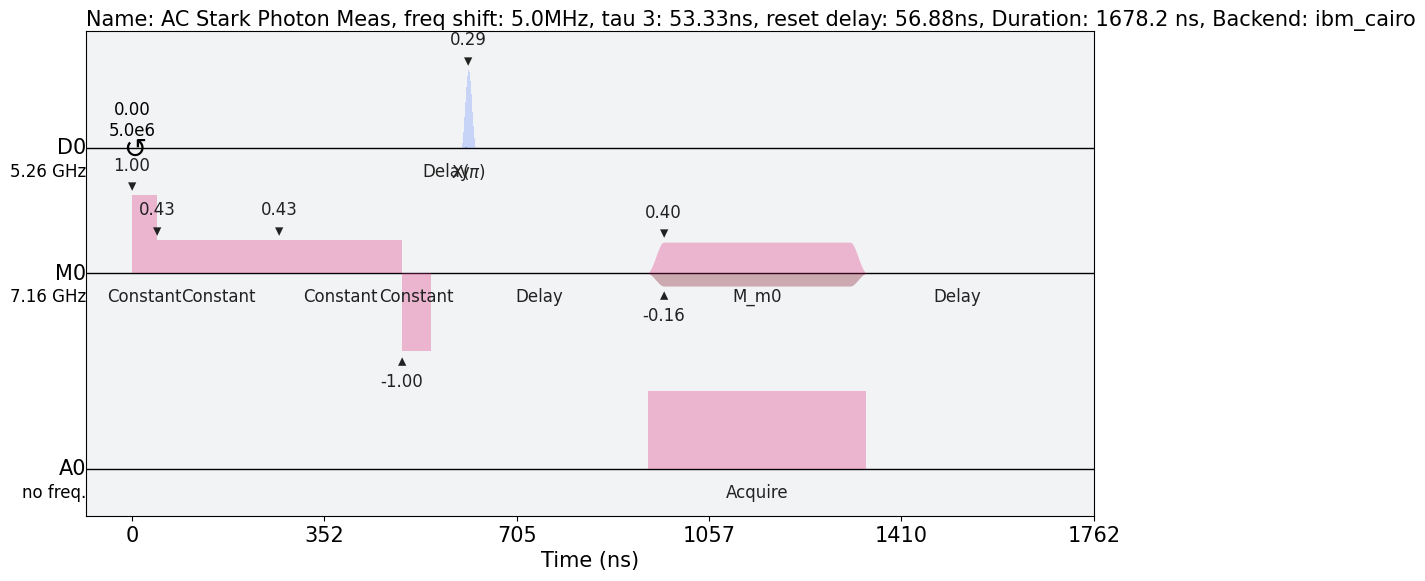

In [75]:
comp_vals = np.array(np.meshgrid(tau_3_est_linspace, qubit_delay_dt_arr)).reshape(2, -1).T

total_exp = []

for val_set in comp_vals:
    tau_3, qubit_delay_dt = val_set
    qubit_delay_dt = int(qubit_delay_dt)
    print(f"qubit delay dt: {qubit_delay_dt}")
    tau_3_dt = get_dt_from(tau_3)
    print(f"tau 3: {tau_3_dt * dt/ns}ns")

    for freq_shift in ac_freq_linspace:
        with pulse.build(
            backend=backend,
            default_alignment='sequential',
            name=f'AC Stark Photon Meas, freq shift: {int(1e2*freq_shift/MHz)/1e2}MHz, tau 3: {int(1e2*tau_3_dt * dt/ns)/1e2}ns, reset delay: {int(1e2*qubit_delay_dt * dt/ns)/1e2}ns'
        ) as reset_meas_sched:
            qubit_chan = pulse.drive_channel(qubit)
            meas_chan = pulse.measure_channel(qubit)
            acq_chan = pulse.acquire_channel(qubit)

            pulse.shift_frequency(freq_shift, qubit_chan)

            pulse.play(
                pulse.Constant(duration=get_dt_from(tau_1), amp=1.0),
                meas_chan
            )
            pulse.play(
                pulse.Constant(duration=get_dt_from(tau_2 - tau_1), amp=measure_pulse.amp),
                meas_chan
            )
            pulse.play(
                pulse.Constant(duration=get_dt_from(tau_2 - tau_1), amp=measure_pulse.amp),
                meas_chan
            )
            pulse.play(
                pulse.Constant(duration=tau_3_dt, amp=-1.0),
                meas_chan
            )
            with pulse.align_left():
                pulse.delay(qubit_delay_dt, qubit_chan)
                pulse.play(x_pulse, qubit_chan)
                pulse.delay(measure_pulse.duration, meas_chan)
            pulse.measure(qubit, pulse.MemorySlot(qubit))
        total_exp.append(reset_meas_sched)

print(len(total_exp))
acquisition_checker(total_exp)

total_exp[-1].draw(
    backend=backend,
    style=stylesheet.IQXDebugging(),
    show_framechange=True,
    show_waveform_info=True,
    show_barrier=True
)

295


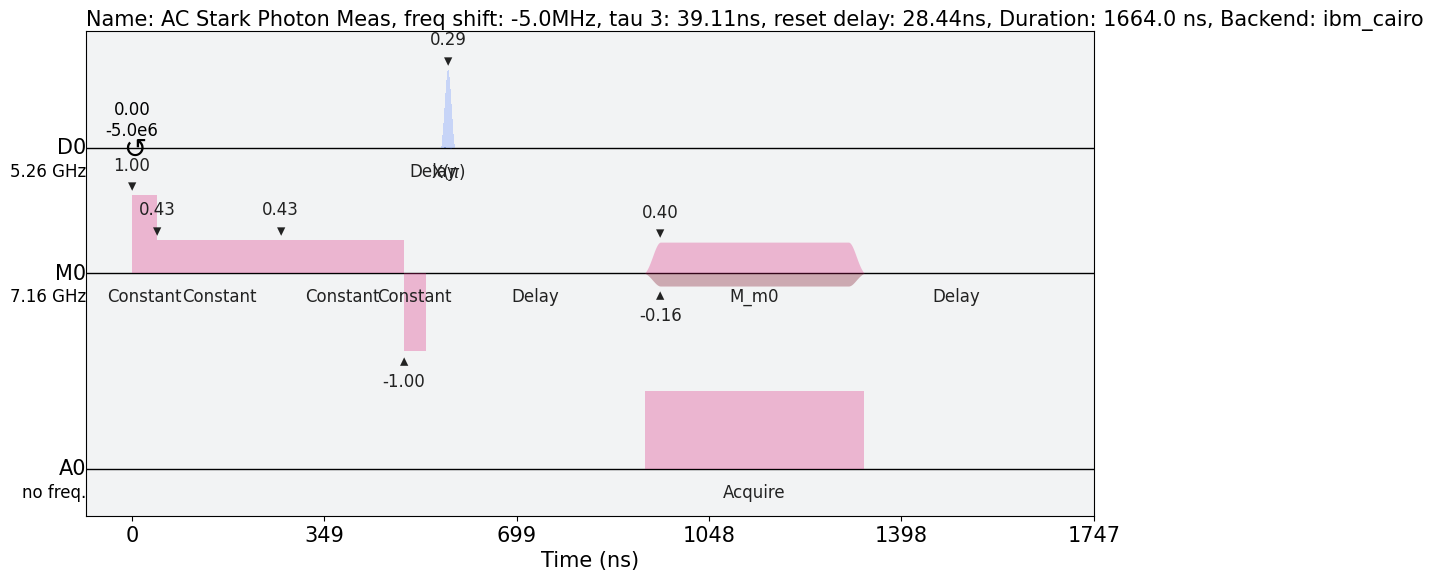

In [76]:
exp_1, exp_2, exp_3 = np.array(total_exp).reshape(3, -1).tolist()

print(len(exp_1))

num_shots = 8192
rep_delay = 499.0 * 1e-6

exp_2[0].draw(
    backend=backend,
    style=stylesheet.IQXDebugging(),
    show_framechange=True,
    show_waveform_info=True,
    show_barrier=True
)

In [79]:
job_experiment = backend.run(exp_3, 
                            meas_level=1, 
                            meas_return='single', 
                            shots=num_shots,
                            rep_delay=rep_delay)

job_monitor(job_experiment)

/Users/chatt07/Desktop/readout_env/lib/python3.9/site-packages/qiskit/compiler/assembler.py:443: RuntimeWarning: Dynamic rep rates are supported on this backend. 'rep_delay' will be used instead of 'rep_time'.
  warnings.warn(


Job Status: job is queued

KeyboardInterrupt: 

In [7]:
job_1 = provider.backend.retrieve_job('cpd916w2zy6g008p14b0')
job_2 = provider.backend.retrieve_job('cpd919xbtqp0008fw010')
job_3 = provider.backend.retrieve_job('cpd91d52zy6g008p14c0')

In [8]:
result_1 = get_results_arr(job_1.result(), qubit)
result_2 = get_results_arr(job_2.result(), qubit)
result_3 = get_results_arr(job_3.result(), qubit)

In [57]:
mean_1 = np.angle(np.mean(result_1, axis=-1))
mean_2 = np.angle(np.mean(result_2, axis=-1))
mean_3 = np.angle(np.mean(result_3, axis=-1))

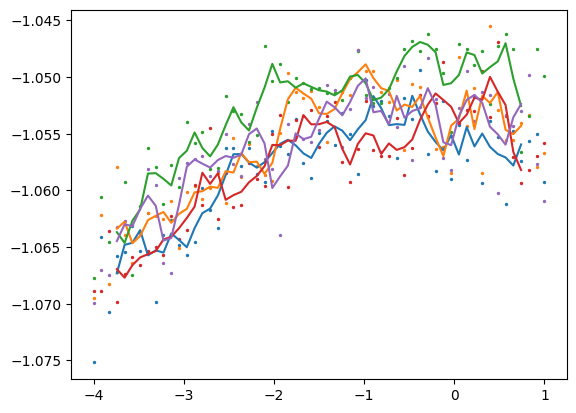

In [63]:
from scipy.optimize import curve_fit

mean_1_ = mean_3.reshape(num_tau_3_exp, -1)
smoothed_mean_1 = np.zeros_like(mean_1_)

tau_3_fit_res = np.zeros_like(mean_1_)
tau_3_freqs = np.zeros(len(tau_3_fit_res))

# plt.plot(ac_freq_linspace/MHz, mean_1_.T)

for ind, res_obj in enumerate(mean_1_):
    plt.scatter(ac_freq_linspace/MHz, res_obj, s=2)
    init_params = [1., -1., 5., -2.]
    smooth_obj = np.convolve(res_obj, np.ones(3) / 3, mode='same')
    smoothed_mean_1[ind] = smooth_obj
    params, cov = curve_fit(gaussian_func_with_offset, ac_freq_linspace/MHz, smooth_obj, init_params, maxfev=2000)
    res = gaussian_func_with_offset(ac_freq_linspace/MHz, *params)
    tau_3_fit_res[ind] = res
    tau_3_freqs[ind] = params[1]

plt.plot(ac_freq_linspace[3:-3]/MHz, smoothed_mean_1[:,3:-3].T)

2.450001371699016
53.33333333333333


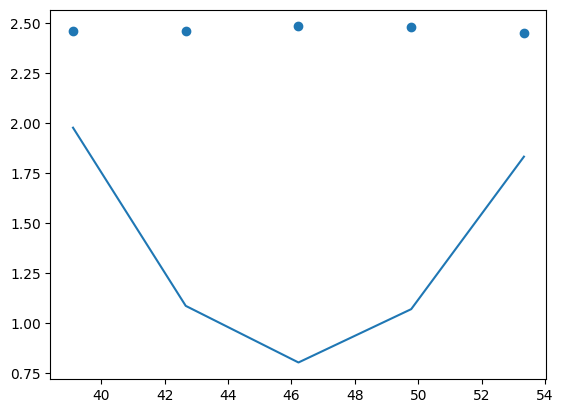

In [64]:
n0 = 42
k = 19.0
c = 0.65 * 2 * np.pi
u = 2.33

ts = tau_3_est_linspace/us - 0.01
theory_photons = n0 * (u**2 + (u + 1)**2 * np.exp(-k * ts) - 2 * u * (u + 1) * np.exp(-0.5 * k * ts) * np.cos(0.5 * c * ts)) - 0.5

photons = -tau_3_freqs/0.65
print(np.min(photons))
print(tau_3_est_linspace[np.argmin(photons)]/ns)

plt.scatter(tau_3_est_linspace/ns, -tau_3_freqs/0.65)
plt.plot(tau_3_est_linspace/ns, theory_photons)
plt.show()